In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

In [7]:
df = pd.read_csv("cleaned_data.csv")

/var/folders/8g/zv0955h54s17sjwt7_k9btb40000gn/T/ipykernel_215/1989269044.py:1: DtypeWarning: Columns (988,1170,1351,1365,1379,1393,1407,1412,1413,1436,1441,1442,1445,1446,1447,1450,1453,1454,1455,1456,1459,1460,1462,1473,1474,1475,1476,1487,1488,1489,1490,1491,1492,1497,1498,1501,1502,1503,1505,1508,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520,1521,1522,1525,1526,1527,1528,1529,1530,1532,1534,1535,1545,1548,1549,1550,1552,1555,1556,1557,1558,1559,1560,1562,1563,1564,1566,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1580,1583,1584,1587,1588,1589,1592,1593,1594,1597,1598,1601,1602,1605,1609,1623,1624,1625,1638,1653,1664,1679,1690,1692,1695,1702,1708,1711,1725,1726,1727,1728,1815,1816,1818,1823,1824,1830,1831,1844,1845,1846,1879,1880,1881,1882,1883,1908,1909,1910,1911,1912,1913,1961,1962,1963,1964,1983,1984,2044,2045,2046,2047,2072,2073,2074,2075,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2100,2101,2102,2103,2108,2109,2110,2111,2160,2259,226

In [8]:
y = df["MD_EARN_WNE_P10"].values
X = df["SAT_AVG"].values
regions, region_index = np.unique(df["REGION_NAME"], return_inverse=True)
R = len(regions)
N= len(y)

In [9]:
#Standardize X
X = (X - np.mean(X))/np.std(X)

In [10]:
S = 100000
alpha = 0.1
beta = 0.1
mu = 0.5
tau = 0.1
sigma = 0.05

In [11]:
b_samples = np.zeros((S))
a_samples = np.zeros((S,R))
m_samples = np.zeros((S))
t_samples = np.zeros((S))
s_samples = np.zeros((S))

In [12]:
a_val = np.zeros(R)
b_val = 0
m_val = 0
t_val = 1
s_val = 10

Log Functiosn

In [13]:
def log_likelihood(y, x, alpha, beta, sigma):
  mu = alpha[region_index] +(beta*x)
  return (-0.5*np.sum(np.log(2*np.pi*sigma**2) + ((y - mu)**2)/(sigma**2)))

In [14]:
def log_prior(beta, alpha, mu_alpha, tau_alpha, sigma):
  #Cauchhy distribution
  lp_beta = np.log(1/(np.pi*5*(1+(beta/5)**2)))
  #Notmal distribution
  lp_alpha = -0.5*np.sum((alpha-mu_alpha)**2 / tau_alpha**2) - (R*np.log(tau_alpha))
  #Normal
  lp_mu_alpha = -0.5*(mu_alpha**2/(50**2))
  #Half cauchy
  if tau_alpha <= 0:
    lp_tau_alpha = -np.inf
  else:
    lp_tau_alpha = np.log(2/np.pi)+np.log(5)-np.log((5**2) + tau_alpha**2)

  #half cauchy
  if sigma <= 0:
    lp_sigma = -np.inf
  else:
    lp_sigma = np.log(2/np.pi) +np.log(5)-np.log((5**2)+(sigma**2))

  return lp_beta + lp_alpha + lp_mu_alpha + lp_tau_alpha + lp_sigma


In [15]:
def log_post(y, x, alpha, beta, mu_alpha, tau_alpha, sigma):
  return log_likelihood(y,x,alpha, beta, sigma) + log_prior(beta, alpha, mu_alpha, tau_alpha, sigma)

Sampling

In [16]:
for s in range(S):
  #sample beta
  b_prop = b_val + np.random.normal(0, beta)
  logA = log_post(y,X,a_val, b_prop, m_val, t_val, s_val) - log_post(y, X, a_val, b_val, m_val, t_val, s_val)
  if np.log(np.random.rand()) < logA:
    b_val = b_prop
  b_samples[s] = b_val

  #sample alpha
  for r in range(R):
    a_prop = a_val.copy()
    a_prop[r] += np.random.normal(0, alpha)
    logA = log_post(y,X,a_prop, b_val, m_val, t_val,s_val) - log_post(y, X, a_val, b_val, m_val, t_val, s_val)
    if np.log(np.random.rand()) < logA:
      a_val[r] = a_prop[r]
  a_samples[s,:] = a_val

  #sample mu
  m_prop = m_val + np.random.normal(0, mu)
  logA = log_post(y,X,a_val, b_val, m_prop, t_val,s_val) - log_post(y, X, a_val, b_val, m_val, t_val, s_val)
  if np.log(np.random.rand()) < logA:
    m_val = m_prop
  m_samples[s] = m_val
  #sample tau
  t_prop = np.abs(t_val+np.random.normal(0, tau))
  logA = log_post(y,X,a_val, b_val, m_val, t_prop,s_val) - log_post(y, X, a_val, b_val, m_val, t_val, s_val)
  if np.log(np.random.rand()) < logA:
    t_val = t_prop
  t_samples[s] = t_val

  #sample sigma
  s_prop = np.exp(np.log(s_val) + np.random.normal(0, sigma))
  logA = log_post(y,X,a_val, b_val, m_val, t_val,s_prop) - log_post(y, X, a_val, b_val, m_val, t_val, s_val)
  if np.log(np.random.rand()) < logA:
    s_val = s_prop
  s_samples[s] = s_val

Visualization

In [17]:
def visualize_outcome(samples, param_name, burn_in=10000):
    samples_post = samples[burn_in:]
    print(param_name)
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.plot(samples_post)
    plt.xlabel("Iteration")
    plt.ylabel(param_name)
    plt.title("Trace Plot")
    
    plt.subplot(1,3,2)
    sns.histplot(samples_post, kde=True, bins=50)
    plt.title("Posterior Distribution")
  
    plt.subplot(1,3,3)
    plot_acf(samples_post, lags=50, ax=plt.gca())
    
    plt.tight_layout()
    plt.show()

Beta


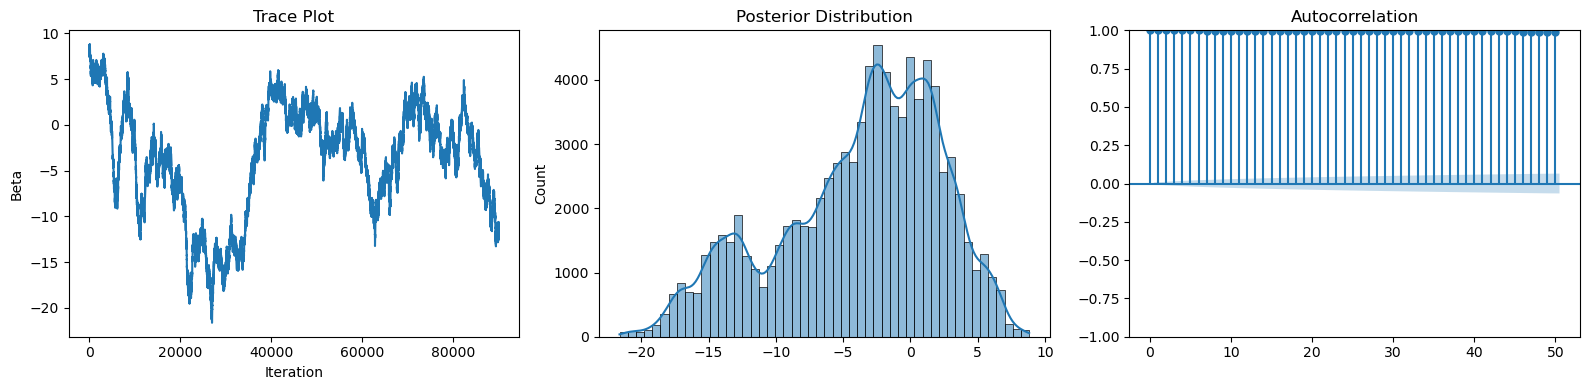

In [18]:
visualize_outcome(b_samples, "Beta")


Alpha - Region: Far West


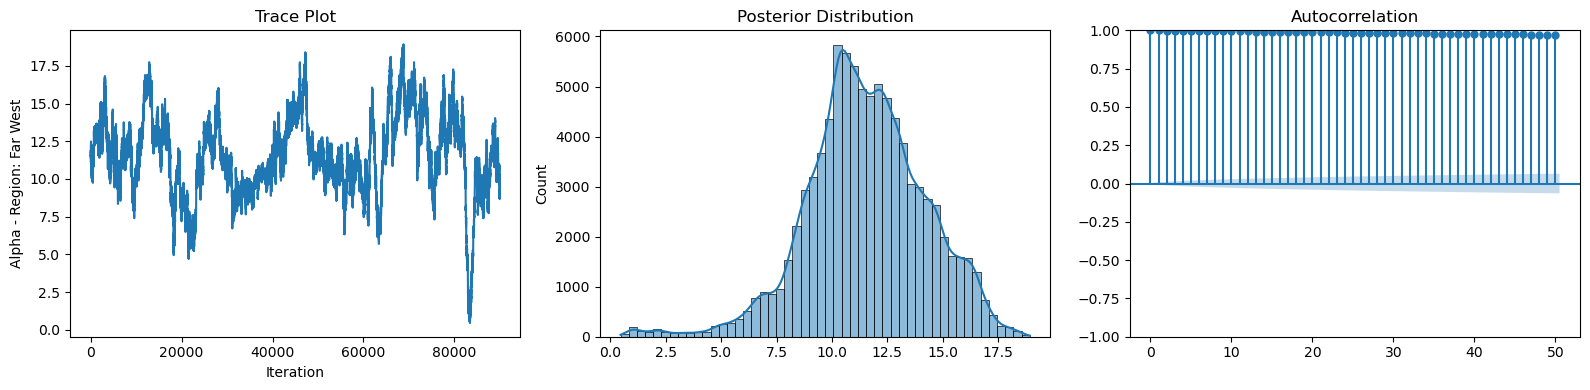

Alpha - Region: Great Lakes


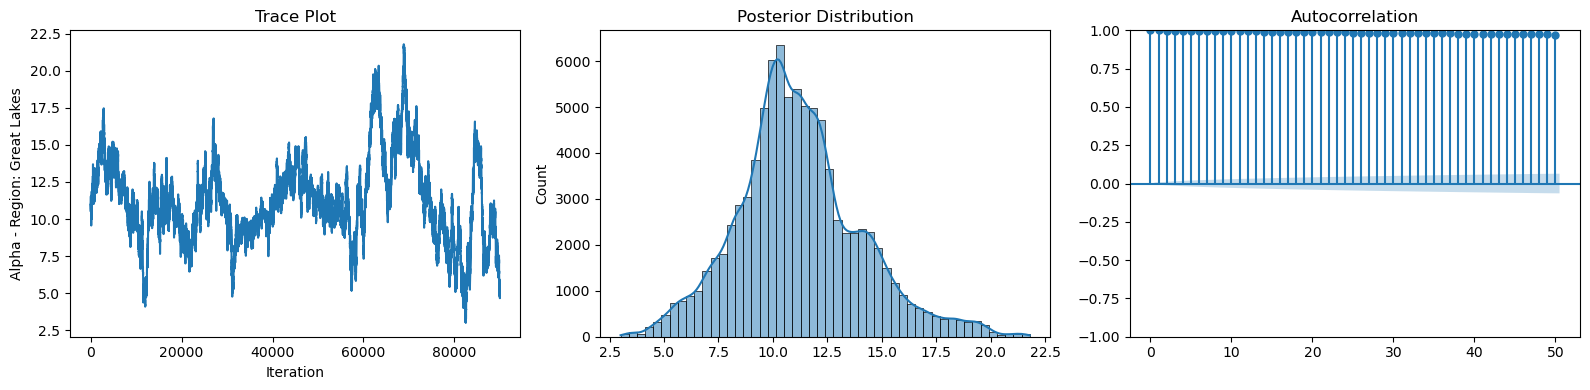

Alpha - Region: Mid East


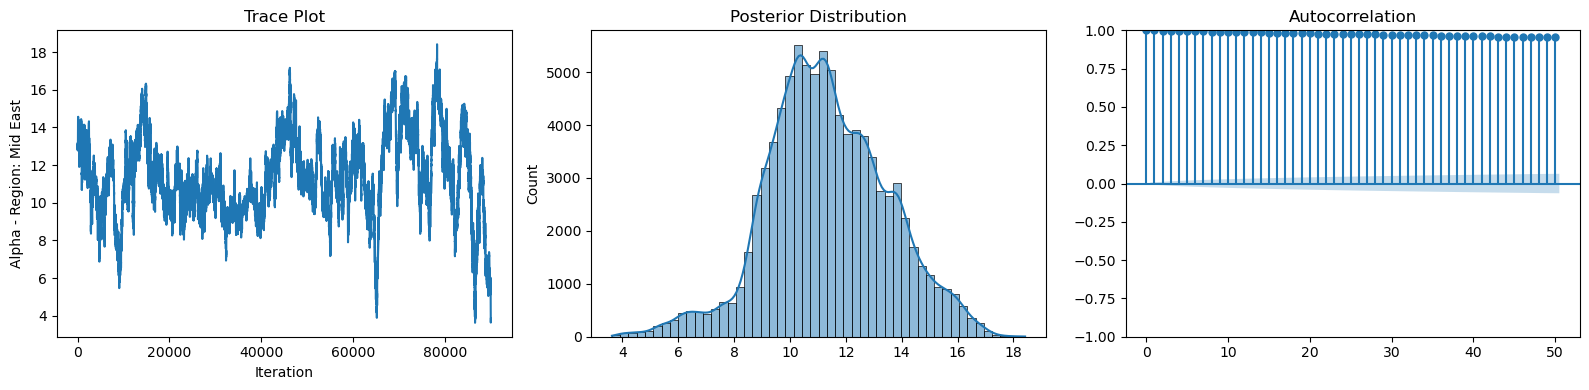

Alpha - Region: New England


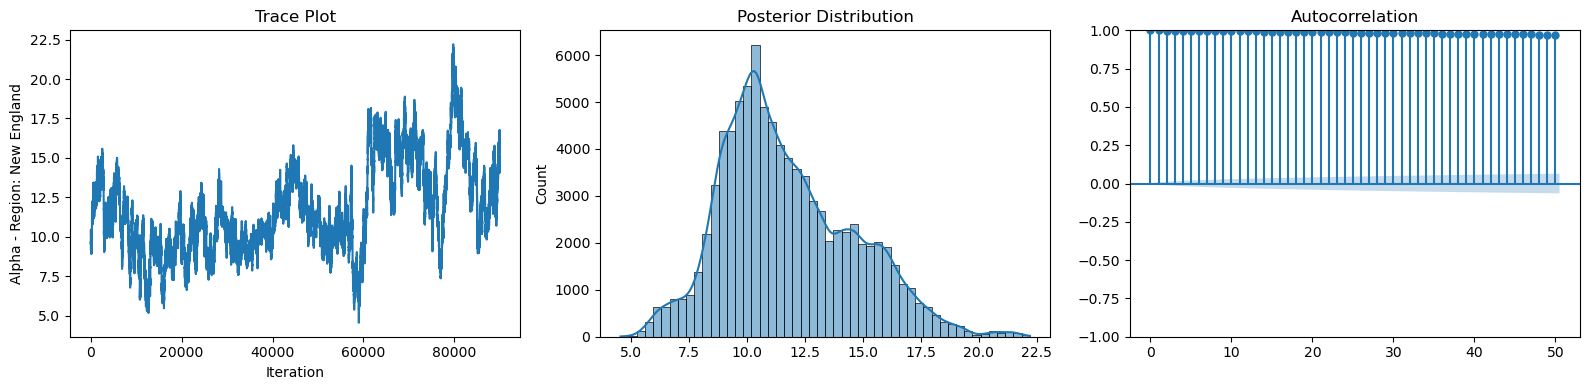

Alpha - Region: Outlying Areas


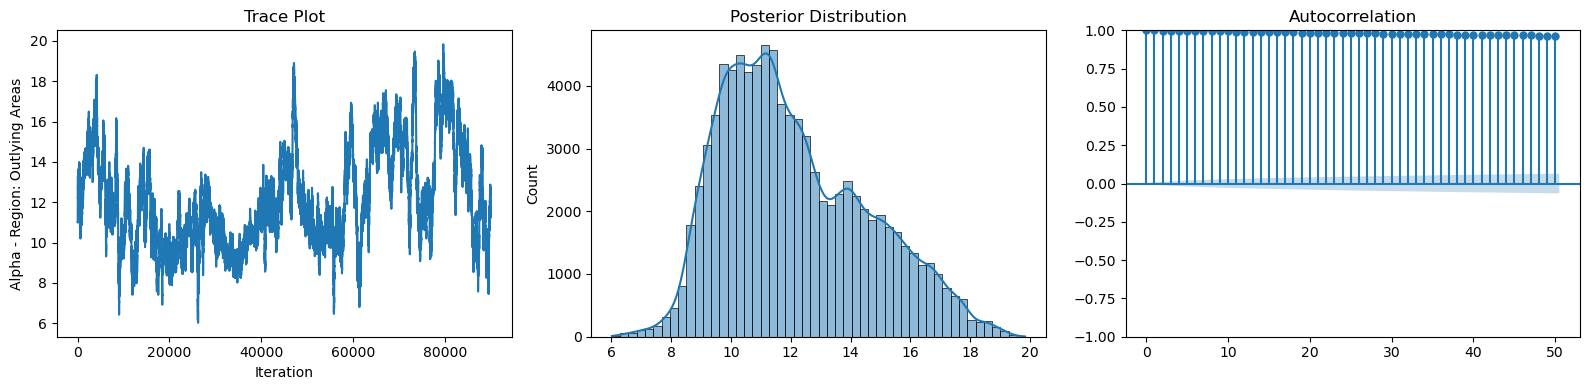

Alpha - Region: Plains


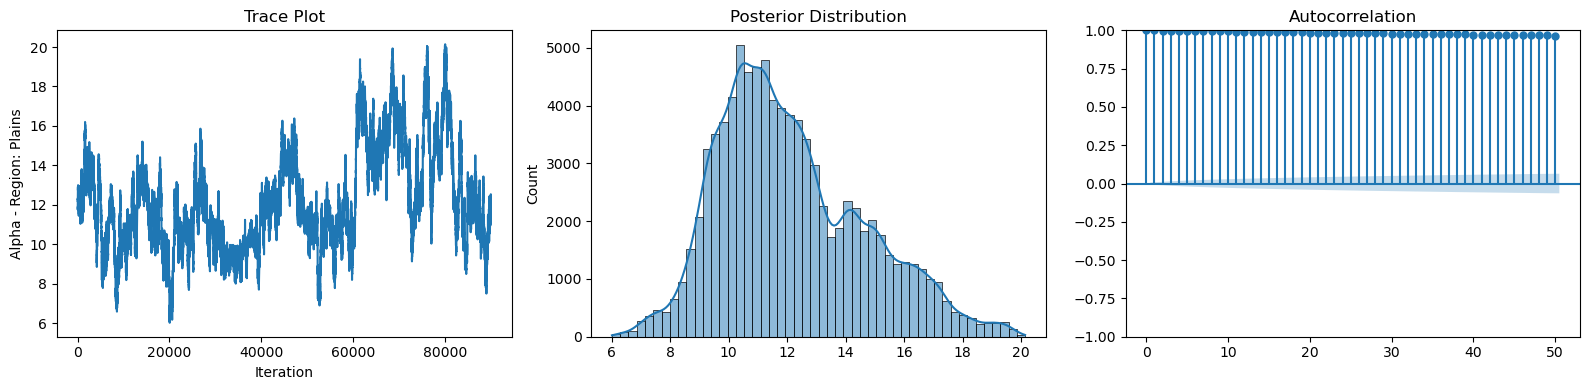

Alpha - Region: Rocky Mountains


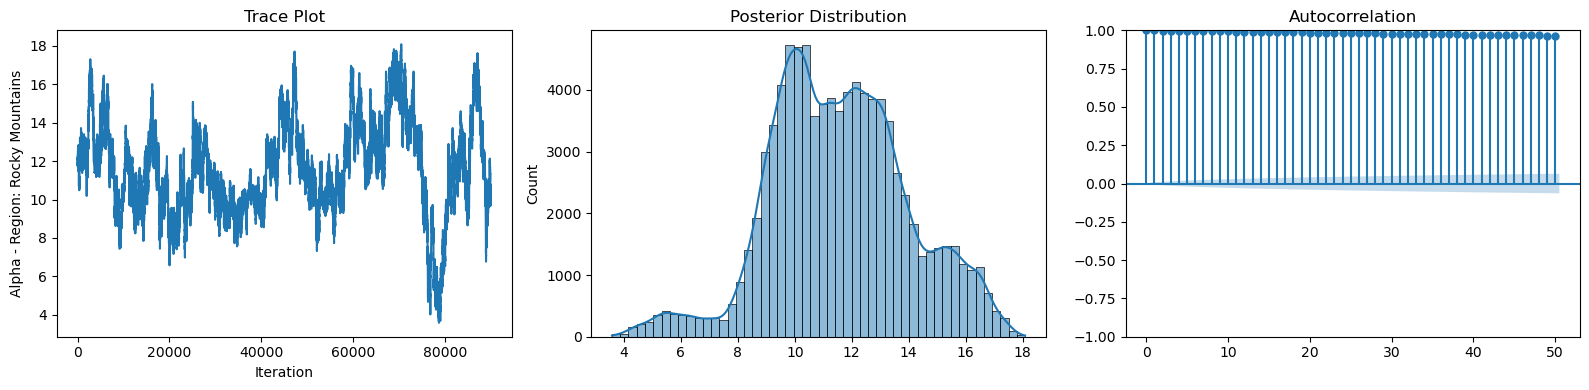

Alpha - Region: Southeast


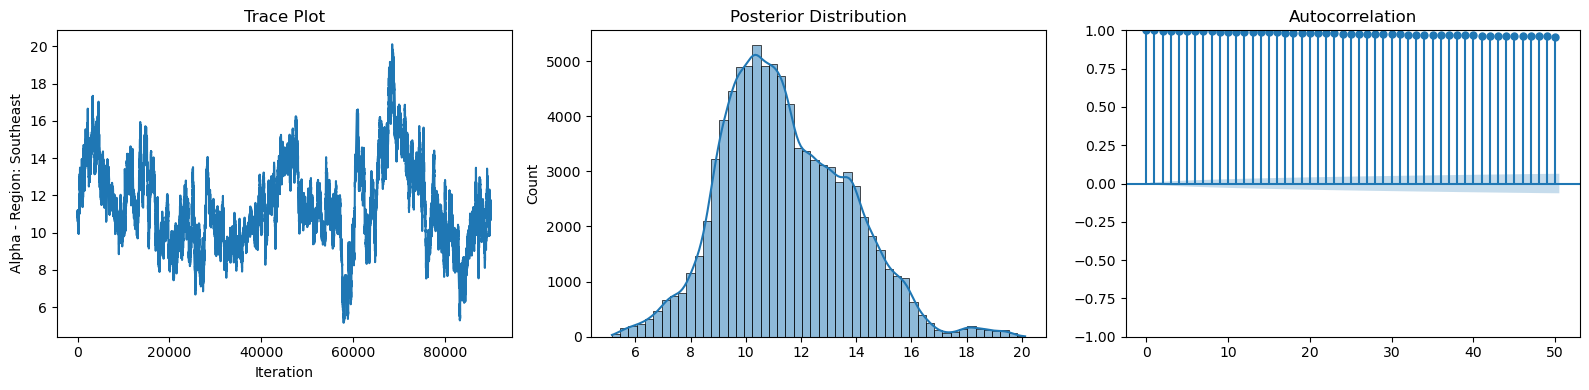

Alpha - Region: Southwest


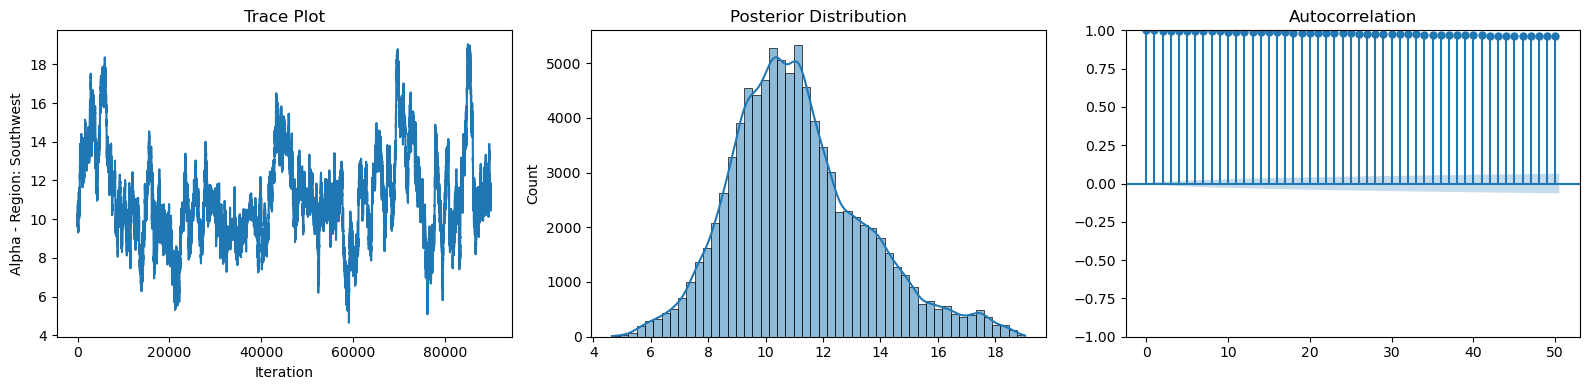

Alpha - Region: U.S. Service Schools


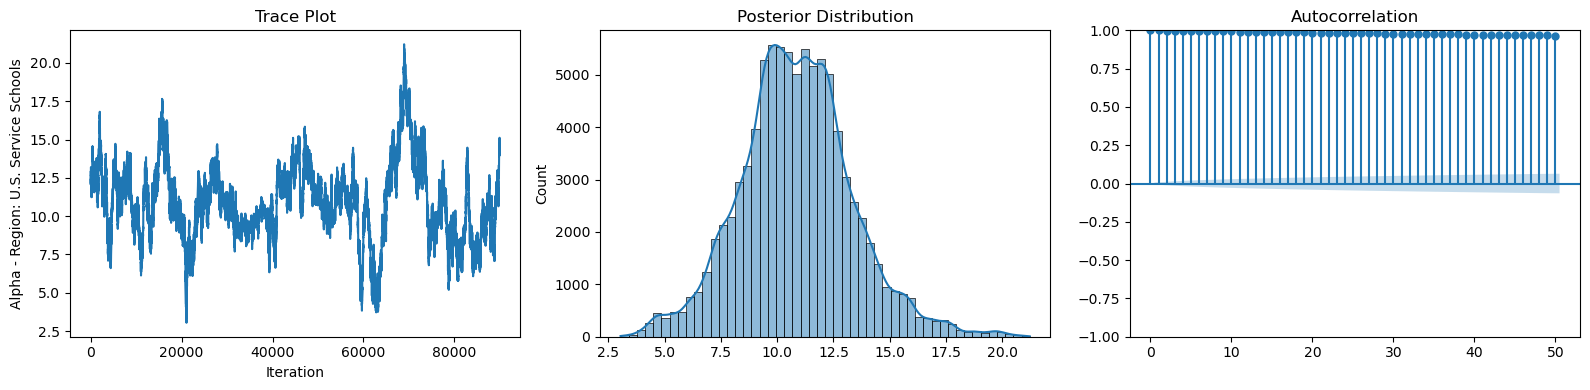

In [19]:
for r in range(R):
    visualize_outcome(a_samples[:,r], f"Alpha - Region: {regions[r]}")


Mu


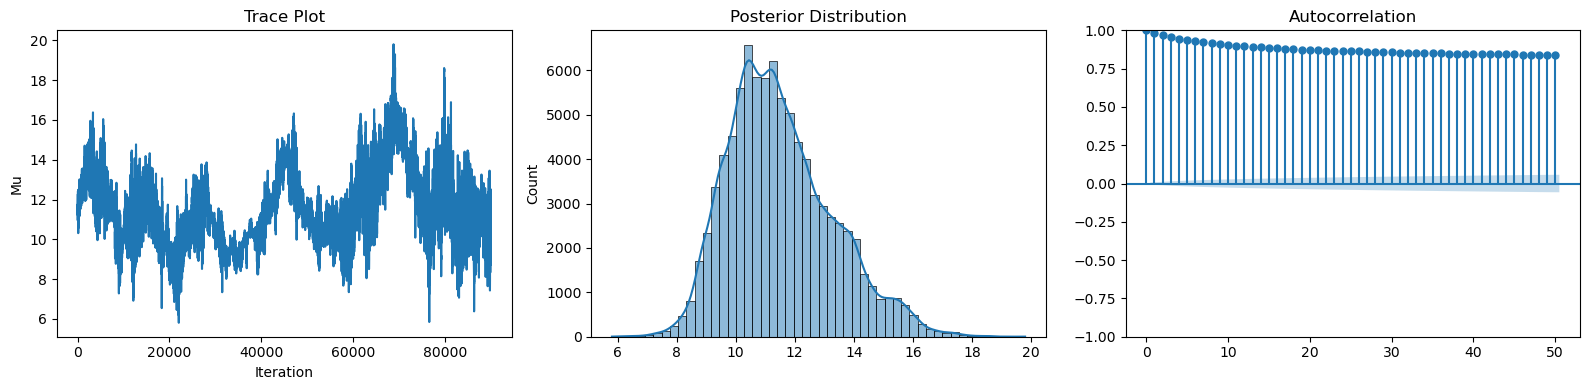

In [20]:
visualize_outcome(m_samples, "Mu")


Tau


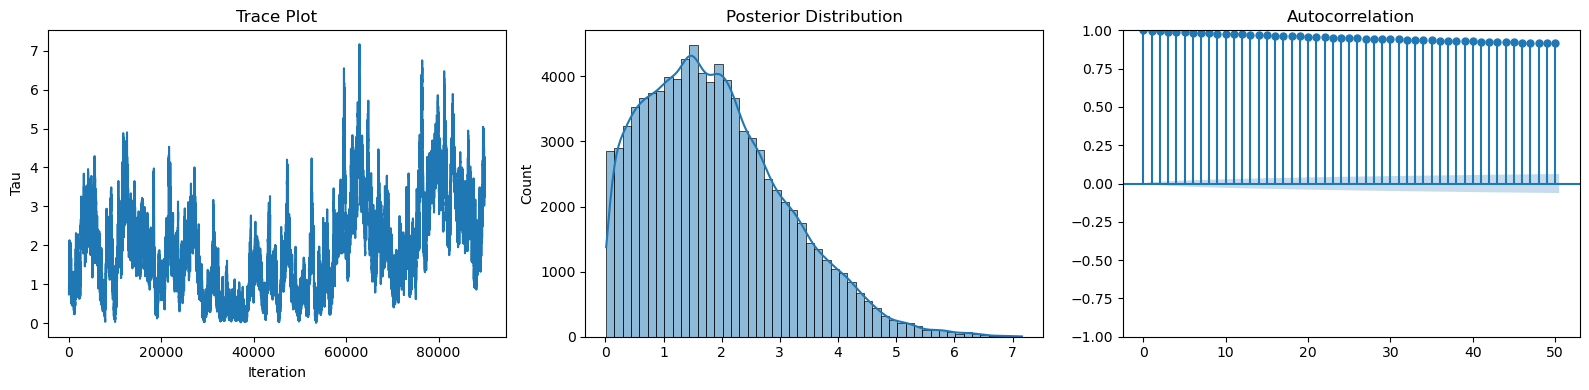

In [21]:
visualize_outcome(t_samples, "Tau")


Sigma


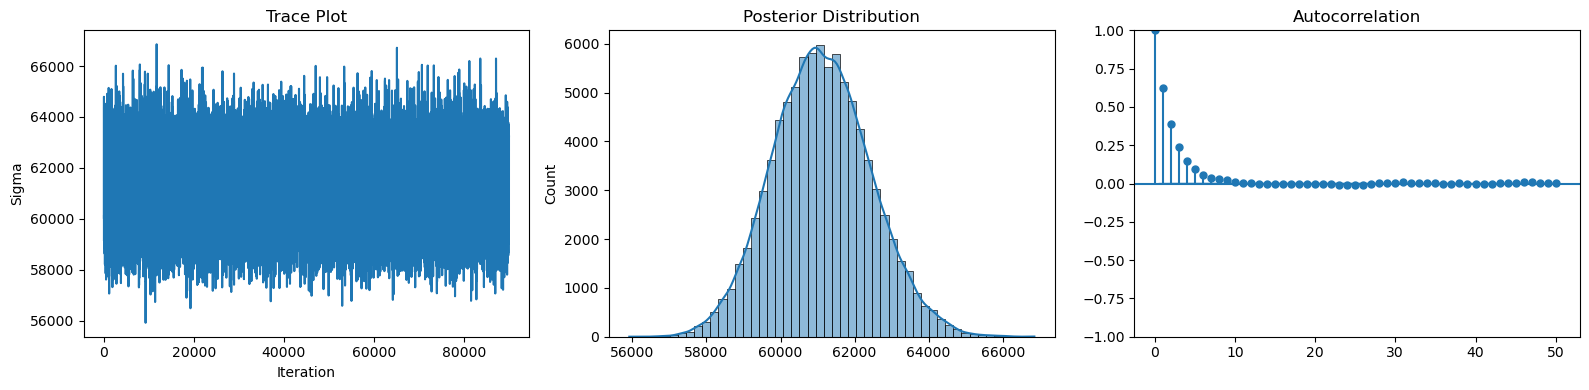

In [22]:
visualize_outcome(s_samples, "Sigma")


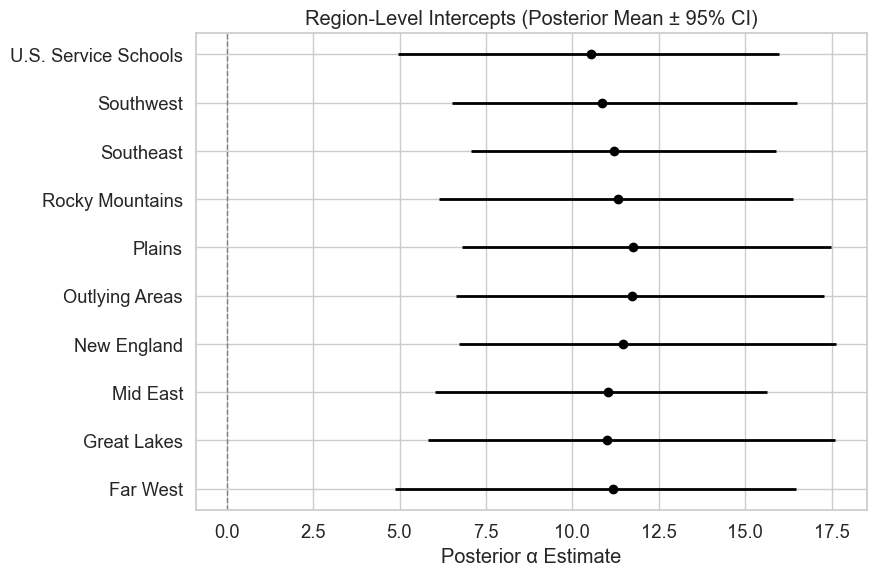

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

means = np.mean(a_samples, axis=0)
lower = np.percentile(a_samples, 2.5, axis=0)
upper = np.percentile(a_samples, 97.5, axis=0)

R = len(regions)
y_pos = np.arange(R)

plt.figure(figsize=(9, 6))

# Interval lines
plt.hlines(y_pos, lower, upper, color='black', linewidth=2)

# Posterior means
plt.plot(means, y_pos, 'o', color='black')

plt.yticks(y_pos, regions)
plt.xlabel("Posterior α Estimate")
plt.title("Region-Level Intercepts (Posterior Mean ± 95% CI)")

plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


In [24]:
import arviz as az
import numpy as np

# ---------------------------
# RESHAPE SAMPLES FOR ARVIZ
# ---------------------------
# These must exist before running this block:
# b_samples: shape (100000,)
# m_samples: shape (100000,)
# a_samples: shape (100000,10)

beta = b_samples.reshape(1, -1)               # (1, 100000)
mu = m_samples.reshape(1, -1)                 # (1, 100000)
alpha_region = a_samples.reshape(1, 100000, 10)  # (1, 100000, 10)

# ---------------------------
# CREATE ARVIZ INFERENCEDATA
# ---------------------------
idata = az.from_dict(
    posterior={
        "beta": beta,
        "mu": mu,
        "alpha_region": alpha_region
    },
    coords={
        "chain": [0],                          # 1 chain
        "draw": np.arange(100000),             # 100k draws
        "alpha_region_dim_0": np.arange(10)    # 10 regions
    },
    dims={
        "beta": ["chain", "draw"],
        "mu": ["chain", "draw"],
        "alpha_region": ["chain", "draw", "alpha_region_dim_0"]
    }
)

# ---------------------------
# COMPUTE ESS
# ---------------------------
ess = az.ess(idata)
ess


<xarray.Dataset> Size: 176B
Dimensions:             (alpha_region_dim_0: 10)
Coordinates:
  * alpha_region_dim_0  (alpha_region_dim_0) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    beta                float64 8B 8.485
    mu                  float64 8B 4.625
    alpha_region        (alpha_region_dim_0) float64 80B 22.88 20.26 ... 26.38

In [ ]:
az.summary(idata, var_names=["beta"])["ess_bulk"]

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


beta    8.0
Name: ess_bulk, dtype: float64

In [29]:
ess_vals = az.ess(idata)
ess_vals.to_dataframe()

,beta,mu,alpha_region
alpha_region_dim_0,,,
0,8.484843,4.625318,22.878098
1,8.484843,4.625318,20.261887
2,8.484843,4.625318,15.835911
3,8.484843,4.625318,2.726123
4,8.484843,4.625318,3.400338
5,8.484843,4.625318,3.023908
6,8.484843,4.625318,20.752912
7,8.484843,4.625318,19.667441
8,8.484843,4.625318,22.703831
